# Лабораторная работа 4. 
# Сетевые алгоритмы. Динамические алгоритмы поиска путей.


## Выполнил студент группы БПИ2301 Спесивцев Даниил Владимирович
***

### Задание

1.  Реализовать алгоритм поиска кратчайшего расстояния между двумя вершинами ориентированного взвешенного графа в соответствии с вариантом. 

2.  Предусмотреть задание графа в виде матрицы смежности/инцидентности, читаемой из файла, либо графически с помощью пользовательского интерфейса. 

3.  Разработать графический интерфейс пользователя с визуализацией графа и отображением кратчайшего расстояния между задаваемыми пользователем вершинами.

4. По результатам работы проанализировать временную сложность работы заданного алгоритма в зависимости от числа узлов и ребер графа.
Данные представить в виде таблицы.



### Алгоритмы:

Алгоритм Флойда-Уоршелла| Алгоритм Дейкстры | Алгоритм Беллмана-Форда | Алгоритм Джонсона| Алгоритм Левита | Алгоритм Йена



### Выполнение:

Задание 1

In [1]:
import numpy as np
from typing import List, Tuple
import heapq

class Graph:
    def __init__(self, adjacency_matrix: np.ndarray):
        self.adjacency_matrix = adjacency_matrix
        self.num_vertices = len(adjacency_matrix)

    def get_neighbors(self, vertex: int) -> List[Tuple[int, int]]:
        neighbors = []
        for i in range(self.num_vertices):
            if self.adjacency_matrix[vertex][i] != 0:
                neighbors.append((i, self.adjacency_matrix[vertex][i]))
        return neighbors
    def set_edge(self, from_vertex: int, to_vertex: int, weight: int = 0):
        self.adjacency_matrix[from_vertex][to_vertex] = weight

def dijkstra(graph: Graph, start: int, end: int) -> Tuple[List[int], int]:
    distances = {v: float('inf') for v in range(graph.num_vertices)}
    distances[start] = 0
    previous_vertices = {v: None for v in range(graph.num_vertices)}
    priority_queue = [(0, start)]
    while priority_queue:
        current_distance, current_vertex = heapq.heappop(priority_queue)
        if current_vertex == end:
            break
        if current_distance > distances[current_vertex]:
            continue
        for neighbor, weight in graph.get_neighbors(current_vertex):
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_vertices[neighbor] = current_vertex
                heapq.heappush(priority_queue, (distance, neighbor))
    path = []
    current_vertex = end
    while current_vertex is not None:
        path.append(current_vertex)
        current_vertex = previous_vertices[current_vertex]
    return path[::-1], distances[end]

def yen(graph: Graph, start: int, end: int, k: int) -> List[Tuple[List[int], int]]:
    first_path, first_distance = dijkstra(graph, start, end)
    k_shortest_paths = [(first_path, first_distance)]
    candidates = []
    
    for k_idx in range(1, k):
        prev_path = k_shortest_paths[k_idx-1][0]
        for i in range(len(prev_path) - 1):
            spur_node = prev_path[i]
            root_path = prev_path[:i+1]
            
            temp_graph = Graph(graph.adjacency_matrix.copy())
            
            for path, _ in k_shortest_paths:
                if len(path) > i and path[:i+1] == root_path:
                    prev_node = path[i]
                    next_node = path[i+1]
                    temp_graph.adjacency_matrix[prev_node][next_node] = 0

            for node in root_path[:-1]:
                temp_graph.adjacency_matrix[node] = np.zeros(graph.num_vertices)
                temp_graph.adjacency_matrix[:, node] = np.zeros(graph.num_vertices)
            
            spur_path, spur_distance = dijkstra(temp_graph, spur_node, end)
            if spur_path and spur_distance != float('inf'):
                total_path = root_path[:-1] + spur_path
                total_distance = sum(graph.adjacency_matrix[total_path[j]][total_path[j+1]] for j in range(len(total_path)-1))
                
                if (total_path, total_distance) not in k_shortest_paths:
                    heapq.heappush(candidates, (total_distance, total_path))
        
        if not candidates:
            break
            
        distance, path = heapq.heappop(candidates)
        k_shortest_paths.append((path, distance))
    
    return k_shortest_paths



Задание 2

In [2]:
def read_graph_from_file(file_path: str) -> Graph:
    try:
        matrix = np.loadtxt(file_path, dtype=float)
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Матрица должна быть квадратной")
        if np.any(matrix < 0):
            raise ValueError("Веса рёбер должны быть неотрицательными")
        return Graph(matrix)
        
    except FileNotFoundError:
        raise FileNotFoundError(f"Файл {file_path} не найден")
    except np.linalg.LinAlgError:
        raise ValueError("Некорректный формат данных в файле")


Задание 3

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets



def graph_to_nx(graph: Graph):
    G = nx.DiGraph()
    G.add_nodes_from(range(graph.num_vertices))
    for i in range(graph.num_vertices):
        for j in range(graph.num_vertices):
            if graph.adjacency_matrix[i][j] != 0:
                G.add_edge(i, j, weight=graph.adjacency_matrix[i][j])
    return G

def visualize_graph(G: nx.DiGraph, paths: List[List[int]] = None):
    plt.figure(figsize=(12, 10))
    pos = nx.circular_layout(G)
    
    nx.draw(G, pos, 
            with_labels=True,
            node_color='lightblue',
            node_size=700,
            font_weight='bold',
            arrows=True)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    if paths:
        colors = ['red', 'green', 'blue', 'orange', 'purple']
        for i, path in enumerate(paths):
            if path:
                path_edges = list(zip(path, path[1:]))
                nx.draw_networkx_edges(G, pos,
                                     edgelist=path_edges,
                                     edge_color=colors[i % len(colors)],
                                     width=2,
                                     label=f'Путь {i+1}')
    
    plt.show()

def interactive_visualization(graph: Graph):
    G = graph_to_nx(graph)
    nodes = list(range(graph.num_vertices))
    @interact(
        start=widgets.Dropdown(options=nodes, description="Начальная вершина:"),
        end=widgets.Dropdown(options=nodes, description="Конечная вершина:"),
        k=widgets.IntSlider(min=1, max=5, step=1, value=1, description="Количество путей:")
    )
    def find_paths(start, end, k):
        try:
            paths = yen(graph, start, end, k)
            
            print(f"Найдено {len(paths)} кратчайших путей от {start} до {end}:")

            for i, (path, distance) in enumerate(paths, 1):
                print(f"Путь {i}: {path}, расстояние: {distance}")

            visualize_graph(G, [path for path, _ in paths])
            
        except Exception as e:
            print(e)
            visualize_graph(G)

interactive_visualization(Graph(read_graph_from_file("graph_matrix.txt").adjacency_matrix))

interactive(children=(Dropdown(description='Начальная вершина:', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), D…

Задание 4

### Вывод

 Размер графа  k  Время (с)
           50  1   0.000698
           50  2   0.002633
           50  3   0.004854
           50  4   0.008070
           50  5   0.010457
           50  6   0.013337
           50  7   0.015630
           50  8   0.019249
           50  9   0.023238
           50 10   0.026052
          100  1   0.002115
          100  2   0.008419
          100  3   0.014902
          100  4   0.018707
          100  5   0.025981
          100  6   0.034150
          100  7   0.042705
          100  8   0.049195
          100  9   0.055189
          100 10   0.060815
          150  1   0.001115
          150  2   0.009117
          150  3   0.018891
          150  4   0.038444
          150  5   0.057341
          150  6   0.076227
          150  7   0.111166
          150  8   0.122161
          150  9   0.136064
          150 10   0.151493
          200  1   0.008696
          200  2   0.035875
          200  3   0.064861
          200  4   0.100832
          200  5   0

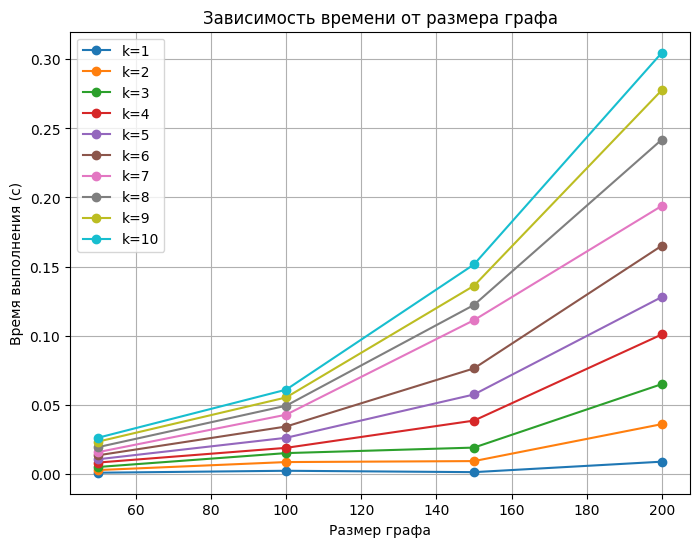

In [4]:
import pandas as pd
import time

def analyze_complexity():
    sizes = [50, 100, 150, 200]
    results = []
    
    for size in sizes:
        matrix = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                if i != j and np.random.random() < 0.3:
                    matrix[i][j] = np.random.randint(1, 10)
        
        graph = Graph(matrix)
        
        for k in range(1, 11):
            start_time = time.time()
            yen(graph, 0, size-1, k)
            end_time = time.time()
            
            results.append({
                'Размер графа': size,
                'k': k,
                'Время (с)': end_time - start_time
            })

    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    
    plt.figure(figsize=(8, 6))
    
    for k in range(1, 11):
        data = df[df['k'] == k]
        plt.plot(data['Размер графа'], 
                data['Время (с)'],
                marker='o',
                label=f'k={k}')
    
    plt.xlabel('Размер графа')
    plt.ylabel('Время выполнения (с)')
    plt.title('Зависимость времени от размера графа')
    plt.legend()
    plt.grid(True)
    plt.show()
    
analyze_complexity()